In [171]:
import pandas as pd
import numpy as np
import linkpred
import networkx as nx
import multiprocessing
import matplotlib.pyplot as plt

#from stellargraph import StellarGraph
#from stellargraph.data import EdgeSplitter
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics 
from math import isclose
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

%matplotlib inline

In [172]:
df = pd.read_csv("../data_collection/data_biden/df_per_grafo_pesato.csv", skipinitialspace=True, na_values='?', keep_default_na=True)   
del df['Unnamed: 0']
del df['id_source']
del df['id_target']

In [173]:
df.source = df.source.astype(str)
df.target = df.target.astype(str)

g = nx.from_pandas_edgelist(df, source="source", target = "target", create_using=nx.MultiDiGraph(), edge_attr = "weights")
#coverto il grafo diretto in indiretto
g = g.to_undirected() #multigrafo (più collegamenti tra gli stessi nodi)

In [174]:
len(g)

22737

In [175]:
comps = list(nx.connected_components(g))
comps_sorted = sorted(comps, key=len, reverse = True)
bcc = nx.subgraph(g, comps_sorted[0]) 

In [176]:
len(bcc)

19675

In [238]:
#creo un campione dei dati a partire dal giant component
def sample_data(g): 
    degree_calc = {node: val for (node, val) in g.degree()}
    degree = dict(sorted(degree_calc.items(), key=lambda item: item[1], reverse = True))
    sample = []
    for k, v in degree.items():
        if(v >=  10):
            sample.append(k)   
    sample_data = g.subgraph(sample)
    return sample_data

In [239]:
g_small = sample_data(bcc)

In [240]:
len(g_small)

963

In [241]:
nx.info(g_small)

'Name: \nType: MultiGraph\nNumber of nodes: 963\nNumber of edges: 4810\nAverage degree:   9.9896'

## Unsupervised methods

### Neighborhood
How many friend we have to share in order to become friends?

#### Common Neighbors
The more friends we share, the more likely we will become friends.

In [242]:
cn = linkpred.predictors.CommonNeighbours(g_small, excluded=g_small.edges()) # We aim to predict only new links, thus we exclude existing ones
cn_results = cn.predict()

top = cn_results.top(20)
for edge, score in top.items():
    print(edge, score)

realDonaldTrump - JoeBiden 121.0
JoeBiden - BernieSanders 70.0
POTUS - JoeBiden 67.0
KamalaHarris - JoeBiden 56.0
JoeBiden - BarackObama 45.0
thehill - JoeBiden 44.0
MSNBC - JoeBiden 44.0
irvinepmaicon - blesamerica 40.0
JoeBiden - CNN 40.0
realDonaldTrump - POTUS 37.0
amyklobuchar - JoeBiden 36.0
JoeBiden - HillaryClinton 35.0
realDonaldTrump - WhiteHouse 33.0
ewarren - JoeBiden 32.0
WhiteHouse - JoeBiden 32.0
thehill - realDonaldTrump 31.0
WhiteHouse - POTUS 31.0
realDonaldTrump - KamalaHarris 30.0
TheDemocrats - JoeBiden 30.0
realDonaldTrump - FoxNews 29.0


#### Jaccard
The more similar our friends circles are, the more likely we will become friends.

In [243]:
jc = linkpred.predictors.Jaccard(g_small, excluded=g_small.edges())
jc_results = jc.predict()

top = jc_results.top(20)
for edge, score in top.items():
    print(edge, score)

vankapro - mdoyle43007 1.0
vankapro - franceintheus 1.0
vankapro - apostelx 1.0
smartusapat1 - helaine6 1.0
rnmukmuk - pissedoffdr 1.0
rnmukmuk - madg_lulu22 1.0
rnmukmuk - diamondsnjeans 1.0
pollymoxie1 - neilfan12 1.0
pollymoxie1 - mi3jules_xo 1.0
pollymoxie1 - calistamueller 1.0
pollymoxie1 - butterflymom322 1.0
pollymoxie1 - bastagal 1.0
pissedoffdr - madg_lulu22 1.0
pissedoffdr - diamondsnjeans 1.0
neilfan12 - mi3jules_xo 1.0
neilfan12 - calistamueller 1.0
neilfan12 - butterflymom322 1.0
neilfan12 - bastagal 1.0
moderaterepand1 - heathwatchman 1.0
moderaterepand1 - brendap1949 1.0


#### Adamic Adar
The more selective our mutual friends are, the more likely we will become friends.

In [244]:
aa = linkpred.predictors.AdamicAdar(g_small, excluded=g_small.edges())
aa_results = aa.predict()

top = aa_results.top(20)
for edge, score in top.items():
    print(edge, score)

realDonaldTrump - JoeBiden 53.32050791410959
JoeBiden - BernieSanders 31.68953512673143
POTUS - JoeBiden 29.48348330082187
KamalaHarris - JoeBiden 21.973771924434434
MSNBC - JoeBiden 17.61369293276543
thehill - JoeBiden 17.38095970785231
JoeBiden - BarackObama 17.172954462465324
realDonaldTrump - POTUS 16.705905427946057
JoeBiden - CNN 16.456231648162813
JoeBiden - HillaryClinton 15.440330278990778
amyklobuchar - JoeBiden 14.620285173406668
realDonaldTrump - WhiteHouse 13.836945538942377
irvinepmaicon - blesamerica 13.76578723583933
ewarren - JoeBiden 13.716400247091247
TheDemocrats - JoeBiden 13.427044247219555
WhiteHouse - JoeBiden 12.211739793180069
realDonaldTrump - FoxNews 12.171186826570327
WhiteHouse - POTUS 12.1250033417007
thehill - realDonaldTrump 12.119355794974782
realDonaldTrump - CNN 11.718346610447334


### Paths
How distant are we?

#### Katz
Katz computes the weighted sum over all the paths between two nodes.

In [245]:
kz = linkpred.predictors.Katz(g_small, excluded=g_small.edges())
kz_results = kz.predict()

top = kz_results.top(10)
for edge, score in top.items():
    print(edge, score)

Computing matrix powers: [############################################################] 5/5
realDonaldTrump - JoeBiden 0.00012109586488800001
JoeBiden - BernieSanders 7.0048569788e-05
POTUS - JoeBiden 6.705716611300002e-05
KamalaHarris - JoeBiden 5.6044315608999995e-05
JoeBiden - BarackObama 4.5036998529e-05
thehill - JoeBiden 4.403723585700001e-05
MSNBC - JoeBiden 4.403684518400001e-05
JoeBiden - CNN 4.003719108499999e-05
irvinepmaicon - blesamerica 4.003331834600001e-05
realDonaldTrump - POTUS 3.703263848599999e-05


### Ranking
How similar we are?

#### SimRank

In [246]:
simrank = linkpred.predictors.SimRank(g_small, excluded=g_small.edges())
simrank_results = simrank.predict(c=0.7)

top = simrank_results.top(10)
for edge, score in top.items():
    print(edge, score)

rnmukmuk - pissedoffdr 0.7000320143305977
rnmukmuk - madg_lulu22 0.7000320143305977
rnmukmuk - diamondsnjeans 0.7000320143305977
pissedoffdr - madg_lulu22 0.7000320143305977
pissedoffdr - diamondsnjeans 0.7000320143305977
madg_lulu22 - diamondsnjeans 0.7000320143305977
maryellen622 - lynnoven 0.7000319708476663
maryellen622 - hellanbiglove 0.7000319708476663
maryellen622 - cokogay 0.7000319708476663
maryellen622 - biennial_piano 0.7000319708476663


## Evaluation and comparison of different unsupervised predictors

In [247]:
import itertools
from linkpred.evaluation import Pair

In [248]:
import random

In [249]:
H = g_small.copy()

# Create test network
test = H.subgraph(random.sample(g_small.nodes(), 200))
print("Test nodes: ", len(test.nodes()))
print("Test edges: ", len(test.edges()))

# Exclude test network from learning phase
training = H.copy()
training.remove_edges_from(test.edges())

print("\nTraining: ", len(training.nodes()))
print("Training: ", len(training.edges()))

# Node set
nodes = list(H.nodes())
nodes.extend(list(test.nodes()))

Test nodes:  200
Test edges:  202

Training:  963
Training:  4608


In [250]:
# Compute the test set and the universe set
test = [Pair(i) for i in test.edges()]


In [251]:
universe = set([Pair(i) for i in itertools.product(nodes, nodes) if i[0]!=i[1]])
len(universe)

463203

In [252]:
cn = linkpred.predictors.CommonNeighbours(training, excluded=training.edges())
cn_results = cn.predict()

In [253]:
jc = linkpred.predictors.Jaccard(training, excluded=training.edges())
jc_results = jc.predict()

In [254]:
aa = linkpred.predictors.AdamicAdar(training, excluded=training.edges())
aa_results = aa.predict()

In [255]:
kz = linkpred.predictors.Katz(training, excluded=training.edges())
kz_results = kz.predict()

Computing matrix powers: [############################################################] 5/5


In [256]:
simrank = linkpred.predictors.SimRank(training, excluded=training.edges())
simrank_results = simrank.predict()

In [257]:
random = linkpred.predictors.Random(training, excluded=training.edges())
rnd_results = random.predict()

In [258]:
cn_evaluation = linkpred.evaluation.EvaluationSheet(cn_results, test, universe)
print("done")
aa_evaluation = linkpred.evaluation.EvaluationSheet(aa_results, test, universe)
print("done")
jc_evaluation = linkpred.evaluation.EvaluationSheet(jc_results, test, universe)
print("done")
kz_evaluation = linkpred.evaluation.EvaluationSheet(kz_results, test, universe)
print("done")
simrank_evaluation = linkpred.evaluation.EvaluationSheet(simrank_results, test, universe)
print("done")
rn_evaluation = linkpred.evaluation.EvaluationSheet(rnd_results, test, universe)
print('done')

done
done
done
done
done
done


In [291]:
def print_res(res):
    top = res.top(10)
    for edge, score in top.items():
        print(edge, score)

In [292]:
print_res(aa_results)
print("")
print("")
print("")
print_res(cn_results)
print("")
print("")
print("")
print_res(jc_results)
print("")
print("")
print("")
print_res(kz_results)
print("")
print("")
print("")
print_res(simrank_results)

realDonaldTrump - JoeBiden 44.28247464299631
JoeBiden - BernieSanders 32.67465765794524
POTUS - JoeBiden 29.804481546013164
KamalaHarris - JoeBiden 22.54949047089637
MSNBC - JoeBiden 18.048548032653244
JoeBiden - BarackObama 17.408312719960556
JoeBiden - HillaryClinton 15.53356794323385
amyklobuchar - JoeBiden 14.941017325378791
ewarren - JoeBiden 14.137381132014736
JoeBiden - CNN 14.026847055092565



realDonaldTrump - JoeBiden 100.0
JoeBiden - BernieSanders 70.0
POTUS - JoeBiden 67.0
KamalaHarris - JoeBiden 56.0
JoeBiden - BarackObama 45.0
MSNBC - JoeBiden 44.0
irvinepmaicon - blesamerica 40.0
amyklobuchar - JoeBiden 36.0
JoeBiden - HillaryClinton 35.0
thehill - JoeBiden 34.0



vankapro - mdoyle43007 1.0
vankapro - glenthecreator 1.0
vankapro - franceintheus 1.0
vankapro - candice81749123 1.0
vankapro - apostelx 1.0
rnmukmuk - pissedoffdr 1.0
rnmukmuk - madg_lulu22 1.0
rnmukmuk - diamondsnjeans 1.0
pollymoxie1 - neilfan12 1.0
pollymoxie1 - mi3jules_xo 1.0



realDonaldTrump - JoeBid

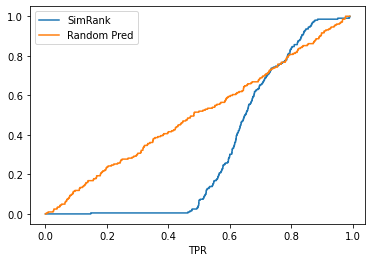

In [262]:
plt.plot(simrank_evaluation.fallout(), simrank_evaluation.recall(), label="SimRank")
plt.plot(rn_evaluation.fallout(), rn_evaluation.recall(), label="Random Pred")

plt.xlabel("FPR")
plt.xlabel("TPR")
plt.legend()
plt.show()

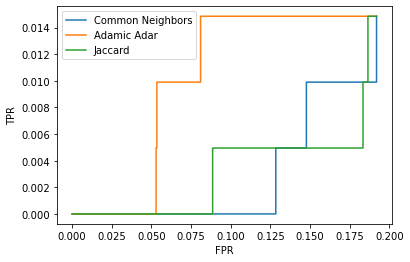

In [271]:
plt.plot(cn_evaluation.fallout(), cn_evaluation.recall(), label="Common Neighbors")
plt.plot(aa_evaluation.fallout(), aa_evaluation.recall(), label="Adamic Adar")
plt.plot(jc_evaluation.fallout(), jc_evaluation.recall(), label="Jaccard")



plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

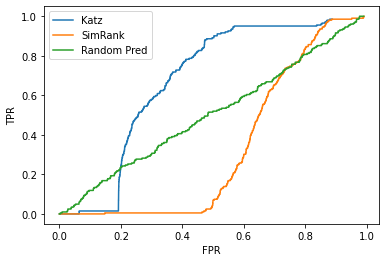

In [272]:
plt.plot(kz_evaluation.fallout(), kz_evaluation.recall(), label="Katz")
plt.plot(simrank_evaluation.fallout(), simrank_evaluation.recall(), label="SimRank")
plt.plot(rn_evaluation.fallout(), rn_evaluation.recall(), label="Random Pred")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

In [274]:
from sklearn.metrics import auc

print("Area Under Roc Curve (AUROC)")
print(f"Common Neigh.: \t {auc(cn_evaluation.fallout(), cn_evaluation.recall())}")
print(f"Adamic Adar: \t {auc(aa_evaluation.fallout(), aa_evaluation.recall())}")
print(f"Jaccard: \t {auc(jc_evaluation.fallout(), jc_evaluation.recall())}")
print(f"Katz: \t {auc(kz_evaluation.fallout(), kz_evaluation.recall())}")
print(f"SimRank: \t {auc(simrank_evaluation.fallout(), simrank_evaluation.recall())}")
print(f"Random: \t {auc(rn_evaluation.fallout(), rn_evaluation.recall())}")

Area Under Roc Curve (AUROC)
Common Neigh.: 	 0.0005333371711170309
Adamic Adar: 	 0.0019228301390876539
Jaccard: 	 0.0005806180389961733
Katz: 	 0.565512806774726
SimRank: 	 0.32406093000547587
Random: 	 0.49692376046661235
